#### Some algebra to work out what kind of sensitivity we need to measure loss

In [5]:
# Imports
import numpy as np
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
#mpl.use('Agg')
import matplotlib.pyplot as plt
#import uncertainties as unc
#from uncertainties import ufloat, umath
#from uncertainties import unumpy as unp
import os
from scipy.special import j0, j1
from matplotlib.ticker import FormatStrFormatter
#import emcee, corner
from tqdm import tqdm

In [6]:
# Matplotlib setup
# mpl.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.titlesize']  = 'large'
mpl.rcParams['axes.labelsize']  = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.formatter.limits'] = [-2,2]
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.alpha'] = 0.4
mpl.rcParams['text.usetex'] = False
# mpl.rcParams['font.family'] = 'sans'
#     mpl.rcParams['font.style'] = 'normal'
#     mpl.rcParams['font.weight'] = 'extra bold'
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = [12,9]
mpl.rcParams['figure.facecolor'] = 'white'
figDir = '../../'
saveFigs=False
if figDir not in os.listdir():
  os.mkdir(figDir)

FileExistsError: [Errno 17] File exists: '../../'

#### Cavity reflectivity
The method essentially relies on measuring the cavity reflectivity vs the ITM reflectivity. So let's look at this in the ideal case.

$$ r_{\mathrm{cav}} = \frac{-r_i + r_e (t_i^2 + r_i^2)e^{-2 i \phi}}{1 - r_i r_e e^{-2i \phi}}, \quad t \equiv \sqrt{T}, \quad r \equiv \sqrt{1 - T - \mathcal{L}}.$$

In the above, $\mathcal{L}$ is the loss we are trying to measure. Of course, we are measuring power, so:

$$\frac{P_{\mathrm{refl}}}{P_{\mathrm{in}}} = \begin{cases}
r_{\mathrm{cav}}^2, \quad \text{ETM aligned} & \\
r_{i}^2, \quad \text{ETM misaligned}
\end{cases}$$

There are two simple corrections that can be applied straight away. Firstly, for the resonant carrier, $P_{in}^{cav} = P_0(J_0(\beta_1)^2 \times J_0(\beta_2)^2) \equiv \gamma P_0$, where $P_0$ is the total power incident on the cavity, and $\beta_{1,2}$ are the modulation depths at the two RF frequencies (assuming the sidebands are perfectly rejected on resonance, which is a reasonable approximation). For the 40m, $\beta_1 \approx 0.18$, $\beta_2 \approx 0.22.$

Secondly, for the cavity, only a fraction of the incident light is coupled to the cavity. This is quantified by the mode-overlap, $\eta$, between the input beam and the cavity eigen-axis. For the 40m, $\eta \approx 0.92$. So, the above relation may be written more accurately as:

$$\begin{aligned} P_{\mathrm{refl}} = \begin{cases}
P_0 \left ( \eta \gamma r_{\mathrm{cav}}^2 + (1-\eta) + \eta [2 - J_0^2(\beta_1) - J_0^2(\beta_2)] \right ), & \text{ETM aligned}  \\
P_0 r_{i}^2, & \text{ETM misaligned}
\end{cases} \end{aligned}.$$

It is the ratio between these that we are after, so let's plot that as a function of loss.

In [7]:
def cavRefl(Lrt, Ti=1.384e-2, Te=13.4e-6, phi=0):
    ti = np.sqrt(Ti)
    ri = np.sqrt(1 - Ti - Lrt/2)
    te = np.sqrt(Te)
    re = np.sqrt(1 - Te - Lrt/2)
    num = -ri + re*(ti**2 + ri**2)*np.exp(-2j*phi)
    den = 1 - ri*re*np.exp(-2j*phi)
    return(num/den)

def powRat(Lrt, Ti=1.384e-2, Te=13.4e-6, phi=0, b1=0.18, b2=0.22, eta=0.92):
    # Enforce physicality
    if Ti < 0 or Ti > 1:
        Ti = 1.384e-2
    if Te < 0 or Te > 1:
        Te = 13.7e-6
    if b1 < 0 or b1 > 0.5:
        b1 = 0.18
    if b2 < 0 or b2 > 0.5:
        b2 = 0
    if eta < 0 or eta > 1:
        eta = 0.92
    if np.any(Lrt < 0) or np.any(Lrt > 1):
        Lrt = 0
    rCav = cavRefl(Lrt, Ti, Te, phi)
    ri = np.sqrt(1 - Ti - Lrt/2)
    #Pl = eta * j0(b1)**2 * j0(b2)**2 * np.abs(rCav)**2 + (1-eta) + 2*eta*j1(b1)**2 + 2*eta*j1(b2)**2
    Pl = eta * j0(b1)**2 * j0(b2)**2 * np.abs(rCav)**2 + (1-eta) + eta*(2 - j0(b1)**2 - j0(b2)**2)
    return(Pl / ri**2)

# For consistency check, compare with Johannes' approximation
def powRatJ(Lrt, Ti=1.384e-2, Te=13.4e-6, phi=0, b1=0.18, b2=0.22, eta=0.92):
    gam = eta * j0(b1)**2 * j0(b2)**2
    #return((1 - 4*gam*(Lrt + Te)/Ti + Ti))
    return((1 - 4*gam*(Lrt + Te)/Ti )*(1+Ti))

Lrt = 1e-6*np.linspace(0,200,50)
#rats = powRat(Lrt)
rats = powRat(Lrt)
ratsJ = powRatJ(Lrt)

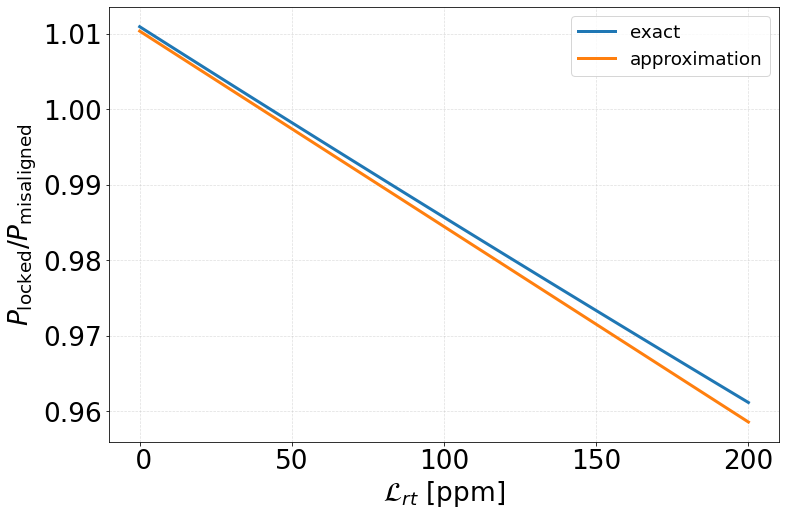

In [8]:
# Make the plot
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(1e6*Lrt, rats, label='exact')
ax.plot(1e6*Lrt, ratsJ, label='approximation')
ax.legend(loc='best')
ax.set_xlabel('$\mathcal{L}_{rt}$ [ppm]')
ax.set_ylabel('$P_{\mathrm{locked}}/P_{\mathrm{misaligned}}$');
ax.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
#fig.savefig(figDir+'/comparison.pdf', bbox_inches='tight')

In [9]:
# Lets add some uncertainty

def ucavRefl(Lrt, Ti=1.384e-2, Te=13.4e-6):
    ti = unp.sqrt(Ti)
    ri = unp.sqrt(1 - Ti - Lrt/2)
    te = unp.sqrt(Te)
    re = unp.sqrt(1 - Te - Lrt/2)
    num = -ri + re*(ti**2 + ri**2)
    den = 1 - ri*re
    return(num/den)

def upowRat(Lrt, Ti=1.384e-2, Te=13.4e-6, b1=0.18, b2=0.22, eta=0.92):
    rCav = ucavRefl(Lrt, Ti, Te)
    ri = unp.sqrt(1 - Ti - Lrt/2)
    #Pl = eta * (j0(b1)**2 * j0(b2)**2) * np.abs(rCav)**2 + (1-eta) + 2*eta*j1(b1)**2 + 2*eta*j1(b2)**2
    Pl = eta * (j0(b1)**2 * j0(b2)**2) * np.abs(rCav)**2 + (1-eta) + eta*(2 - j0(b1)**2 - j0(b2)**2)
    return(Pl / ri**2)

TITM = ufloat(1.384e-2, 0.01e-2)
TETM = ufloat(13.7e-6, 3e-6)
b1 = 0.18
b2 = 0.22
eta = ufloat(0.92, 0.03)

ratsUnc = upowRat(Lrt, TITM, TETM, b1, b2, eta)

NameError: name 'ufloat' is not defined

In [ ]:
# Make the plot
fig2, ax2 = plt.subplots(1,1,figsize=(12,8))
ax2.plot(1e6*Lrt, unp.nominal_values(ratsUnc), label='Numerical Conversion Function')
ax2.fill_between(1e6*Lrt, unp.nominal_values(ratsUnc) - unp.std_devs(ratsUnc), 
                 unp.nominal_values(ratsUnc) + unp.std_devs(ratsUnc), alpha=0.5,color='xkcd:orange',
                label='$T_1 \pm 0.01 \%, T_2 \pm 3 \ \mathrm{ppm}, \eta \pm 5 \%$')
ax2.legend(loc='best')
ax2.set_xlabel('Round Trip Loss [ppm]',fontsize=24)
# ax2.set_xlabel('$\mathcal{L}_{rt}$ [ppm]')
ax2.set_ylabel('$P_{\mathrm{locked}}/P_{\mathrm{misaligned}}$');
ax2.set_xlim([0,200])
ax2.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
# fig2.suptitle('Systematic uncertainties on loss measurement');
fig2.savefig(figDir+'/systUncLoss.pdf', rasterized=True, bbox_inches='tight')

In [ ]:
# Yet another way to do this is to use emcee
mu = np.array([1.384e-2, 13.7e-6, 0.92, 0.18, 0.22])
sigs = np.array([0.01e-2, 3e-6, 0.03, 0.01, 0.01])
lb = np.array([0, 0, 0, 0, 0])
ub = np.array([1, 1, 1, 0.4, 0.4])
cov = np.dot(np.diag(sigs), np.diag(sigs))
icov = np.linalg.inv(cov)


def lnProb(x, mu, icov, lb, ub):
    if np.any(x < lb) or np.any(x > ub):
        return(-np.inf)
    else:
        diff = x - mu
        return(-np.dot(diff, np.dot(diff, icov))/2)
    
# Set up the emcee
nDim = 5
nWalkers = 50#0
nBurnin = 2000
nSamples = 2000
sampler = emcee.EnsembleSampler(nWalkers, nDim, lnProb, args=[mu, icov, lb, ub])
p0 = emcee.utils.sample_ball(mu, sigs, size=nWalkers)
# Actually run the MCMC and look at the sampling, check for unphysical values
pos, prob, state = sampler.run_mcmc(p0, nBurnin)
sampler.reset()
sampler.run_mcmc(pos, nSamples);

In [ ]:
fig3, ax3 = plt.subplots(nDim,nDim, figsize=(16,16))
samples = np.copy(sampler.flatchain)
samples[:,0] *= 100
samples[:,1] *= 1e6
corner.corner(samples, fig=fig3);
for ii in ax3:
    for jj in ii:
        jj.tick_params(labelsize='medium')
        
#fig3.savefig(figDir+'/MCsamples.pdf', bbox_inches='tight', dpi=80)

In [ ]:
fig4, ax4 = plt.subplots(1,1,figsize=(12,8))
for ii in tqdm(sampler.flatchain[np.random.randint(len(sampler.flatchain), size=500)]):
    ratsMC = powRat(Lrt, Ti=ii[0], Te=ii[1], phi=0, b1=ii[3], b2=ii[4], eta=ii[2])
    ax4.plot(1e6*Lrt, ratsMC, color="xkcd:peach", alpha=0.15, linewidth=0.5)

# ax4.fill_between(1e6*Lrt, unp.nominal_values(ratsUnc) - unp.std_devs(ratsUnc), 
#                  unp.nominal_values(ratsUnc) + unp.std_devs(ratsUnc), alpha=0.8,color='xkcd:lilac',
#                 label='$T_I \pm 0.01 \%, T_E \pm 3 \ \mathrm{ppm}, \eta \pm 5 \%$')
    
ax4.plot(1e6*Lrt, rats, color="xkcd:royal blue", alpha=0.8, linewidth=2.0)
#for ii in tqdm(sampler.flatchain):
#    ratsMC = powRat(Lrt, Ti=ii[0], Te=ii[1], phi=0, b1=ii[3], b2=ii[4], eta=ii[2])
#    ax4.plot(1e6*Lrt, ratsMC, '.', rasterized=True, alpha=0.01, color='xkcd:ruby', linewidth=0.4);

ax4.set_xlim(0,200)
ax4.set_ylim(0.955,1.015)

ax4.set_xlabel(u'$\mathcal{L}$ [ppm]')
ax4.set_ylabel(u'$P_{\mathrm{r}}/P_{1}$');

legend_elements = [
    Line2D([0], [0], color='xkcd:royal blue', lw=2, alpha=0.8, label='Numerical Conversion Function'),
#     Patch(facecolor='xkcd:lilac', edgecolor='xkcd:lilac', alpha=0.8, label='Calculated Compound Uncertainty'),
    Line2D([0], [0], color='xkcd:peach', lw=2, alpha=0.8, label='MC Uncertainty Simulation (N=500)'),
                  ]

ax4.legend(handles=legend_elements, loc=1)

ax4.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
fig4.savefig(figDir+'/MCloss.pdf',bbox_inches='tight')

In [ ]:
# It is simple enough to invert this approach, and back out the model parameters given a measurement
# First, the Bayesian functions
def lnPrior(theta, mu, icov, lb, ub):
    if np.any(theta < lb) or np.any(theta > ub):
        return(-np.inf)
    else:
        diff = theta - mu
        return(-np.dot(diff, np.dot(diff, icov))/2)
    
def lnLike(theta, dat):
    Titm, Tetm, eta, b1, b2, L, sigma = theta
    ratTemp = powRat(L, Ti=Titm, Te=Tetm, eta=eta, b1=b1, b2=b2, phi=0)
    return(-0.5 * np.sum(np.log(2 * np.pi * sigma**2) + (ratTemp - dat)**2 / sigma**2))

def lnPost(theta, mu, icov, lb, ub, dat):
    return(lnPrior(theta, mu, icov, lb, ub) + lnLike(theta, dat))

# Next, setup the sampler
mu = np.array([1.384e-2, 13.7e-6, 0.92, 0.18, 0.22, 30e-6, 0.002])
sigs = np.array([0.005e-2, 3e-6, 0.02, 0.01, 0.01, 50e-6, 0.001])
lb = np.array([0, 0, 0, 0, 0, 0, 0])
ub = np.array([1, 1, 1, 0.4, 0.4, 1000e-6, 0.5])
cov = np.dot(np.diag(sigs), np.diag(sigs))
icov = np.linalg.inv(cov)
dat = 1.006

nDim = 7
nWalkers = 250#0
nBurnin = 2000
nSamples = 2000
sampler = emcee.EnsembleSampler(nWalkers, nDim, lnPost, args=[mu, icov, lb, ub, dat])
priorSampler = emcee.EnsembleSampler(nWalkers, nDim, lnPrior, args=[mu, icov, lb, ub])

p0 = emcee.utils.sample_ball(mu, sigs, size=nWalkers)
pos, prob, state = priorSampler.run_mcmc(p0, nBurnin)
priorSampler.reset()
p0, prob, state = priorSampler.run_mcmc(pos, nSamples);

# Actually run the MCMC and look at the sampling, check for unphysical values
pos, prob, state = sampler.run_mcmc(p0, nBurnin)
sampler.reset()
sampler.run_mcmc(pos, nSamples);

In [ ]:
fig5, ax5 = plt.subplots(nDim-1,nDim-1, figsize=(20,20))
samples = np.copy(sampler.flatchain)
samples = np.delete(samples, 5, axis=1)
samples[:,0] *= 100
samples[:,1] *= 1e6
corner.corner(samples, 
              show_titles=True,
              title_fmt='.2f', linewidth=2,
              labels=['$T_{\mathrm{I}} [\%]$', '$T_{\mathrm{E}}$ [ppm]', '$\eta$', '$\\beta_{1}$', '$\\beta_{2}$', '$\sigma$'],
              fig=fig5, hist_kwargs={'density':True, 'linewidth':3});
priors, _, _ = priorSampler.run_mcmc(p0, nSamples);
priors = np.delete(priorSampler.flatchain, 5, axis=1)
priors[:,0] *= 100
priors[:,1] *= 1e6
corner.corner(priors, color='xkcd:bright orange', alpha=0.05, fig=fig5, linewidth=3, hist_kwargs={'density':True, 'linewidth':3, 'linestyle':'--', 'alpha':0.5})
for ii in ax5:
    for jj in ii:
        jj.tick_params(labelsize='medium')
ax5[5,5].xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
ax5[5,0].yaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        
#fig5.savefig(figDir+'/posterior_modelParams_XARM.pdf', bbox_inches='tight', dpi=80)

In [ ]:
# And a dedicated one for the loss histogram
fig6, ax6 = plt.subplots(1,1,figsize=(16,9))
ax6.hist(1e6*sampler.flatchain[:,5], density=True, bins=100, histtype='step',linewidth=3, label='Posterior', color='xkcd:charcoal');
ax6.hist(1e6*priorSampler.flatchain[:,5], density=True, bins=100, histtype='step',linewidth=3, label='Prior', color='xkcd:bright orange');
ax6.set_xlabel('$\mathcal{L}_{\mathrm{RT}}$');
ax6.set_ylabel('PDF');
qq = 1e6*corner.quantile(sampler.flatchain[:,5],[0.25, 0.5, 0.75])
ax6.set_title('$\mathcal{{L}}_{{\mathrm{{RT}}}} = {} ^{{+{}}} _{{-{}}}$'.format(round(qq[1],1), round(qq[1]-qq[0],0), round(qq[2]-qq[1],0)))
ax6.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
ax6.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax6.set_xlim([0,200]);
ax6.legend(loc='best')
#fig6.savefig(figDir+'/posterior_Loss_XARM.pdf', bbox_inches='tight', dpi=80)